In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,mean_squared_error,confusion_matrix
%matplotlib inline
Data = pd.read_csv('/content/online_retail_problem2.csv',encoding= 'unicode_escape')
Data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12-01-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12-01-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12-01-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12-01-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12-01-2010 08:26,3.39,17850.0,United Kingdom


In [ ]:
#Formatting Date/Time
Data['InvoiceDate'] = pd.to_datetime(Data['InvoiceDate'])

#Strings
Data['Description'] = Data['Description'].str.replace('.','').str.upper().str.strip()
Data['Description'] = Data['Description'].replace('\s+',' ',regex = True)
Data['InvoiceNo'] = Data['InvoiceNo'].astype(str).str.upper()
Data['StockCode'] = Data['StockCode'].str.upper()
Data['Country'] = Data['Country'].str.upper()
Data.head()

<ipython-input-7-6c255a688f75>:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Data['Description'] = Data['Description'].str.replace('.','').str.upper().str.strip()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,UNITED KINGDOM
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,UNITED KINGDOM
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,UNITED KINGDOM
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,UNITED KINGDOM
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART,6,2010-12-01 08:26:00,3.39,17850.0,UNITED KINGDOM


In [ ]:
# unnecessary transaction
#Listing Some Irrelevant StockCodes
Irrelevant = Data['StockCode'].unique()
Irrelevant.sort()
print('Irrelevant Transactions: \n',Irrelevant[::-1][:4])
#Quantity and UnitPrice Summary
Data.describe().iloc[:,:2]

Irrelevant Transactions: 
 ['S' 'POST' 'PADS' 'M']


,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [ ]:
import  scipy as sp, scipy.stats

In [ ]:
#Outliers and Irrelevant Values
#Dropping all stockcodes that contain only strings
CodeTypes = list(map(lambda codes: any(char.isdigit() for char in codes), Data['StockCode']))
IrrelevantCodes = [i for i,v in enumerate(CodeTypes) if v == False]
Data.drop(IrrelevantCodes , inplace = True)
#Removing Outliers Based on Z-score
Data = Data[(np.abs(sp.stats.zscore(Data['UnitPrice']))<3) & (np.abs(sp.stats.zscore(Data['Quantity']))<5)]

In [ ]:
# Missing & Incorrect Values
Data.drop(Data[(Data.Quantity>0) & (Data.InvoiceNo.str.contains('C') == True)].index, inplace = True)
Data.drop(Data[(Data.Quantity<0) & (Data.InvoiceNo.str.contains('C') == False)].index, inplace = True)
Data.drop(Data[Data.Description.str.contains('?',regex=False) == True].index, inplace = True)
Data.drop(Data[Data.UnitPrice == 0].index, inplace = True)

for index,value in Data.StockCode[Data.Description.isna()==True].items():
    if pd.notna(Data.Description[Data.StockCode == value]).sum() != 0:
        Data.Description[index] = Data.Description[Data.StockCode == value].mode()[0]
    else:
        Data.drop(index = index, inplace = True)
        
Data['Description'] = Data['Description'].astype(str)

In [ ]:
#Incorrect Prices
StockList = Data.StockCode.unique()
CalculatedMode = map(lambda x: Data.UnitPrice[Data.StockCode == x].mode()[0],StockList)
StockModes = list(CalculatedMode)
for i,v in enumerate(StockList):
    Data.loc[Data['StockCode']== v, 'UnitPrice'] = StockModes[i]

There are also some incorrect customer IDs that for two different countries we have the same customer ID. We will fix the duplicate values by grouping the dataframe by 'CustomerID' and if any customer belongs to more than two countries, we replace the incorrect value with the mode value of the customer's country.

In [ ]:
#Customers with Different Countries
Customers = Data.groupby('CustomerID')['Country'].unique()
Customers.loc[Customers.apply(lambda x:len(x)>1)]

CustomerID
12370.0           [CYPRUS, AUSTRIA]
12394.0          [BELGIUM, DENMARK]
12417.0            [BELGIUM, SPAIN]
12422.0    [AUSTRALIA, SWITZERLAND]
12429.0          [DENMARK, AUSTRIA]
12431.0        [AUSTRALIA, BELGIUM]
12455.0             [CYPRUS, SPAIN]
12457.0       [SWITZERLAND, CYPRUS]
Name: Country, dtype: object

In [ ]:
#Fixing Duplicate CustomerIDs
for i,v in Data.groupby('CustomerID')['Country'].unique().items():
    if len(v)>1:
        Data.Country[Data['CustomerID'] == i] = Data.Country[Data['CustomerID'] == i].mode()[0]

#Adding Desired Features
Data['FinalPrice'] = Data['Quantity']*Data['UnitPrice']
Data['InvoiceMonth'] = Data['InvoiceDate'].apply(lambda x: x.strftime('%B'))
Data['Day of week'] = Data['InvoiceDate'].dt.day_name()


<ipython-input-17-71485b1c6be3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data.Country[Data['CustomerID'] == i] = Data.Country[Data['CustomerID'] == i].mode()[0]


In [ ]:
Data.sample()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,FinalPrice,InvoiceMonth,Day of week
308179,563940,21394,RED POLKADOT BEAKER,48,2011-08-22 09:30:00,0.39,17416.0,UNITED KINGDOM,18.72,August,Monday


For example customer segmentation, in particular, means grouping customers together based on similar features or properties.

Now there's one thing to note is when grouping customers based on properties: the properties you choose to group the customers must be relevant to the criteria based on which you want to group them.

To segmenting customer, there are some metrics that we can use, such as when the customer buy the product for last time, how frequent the customer buy the product, and how much the customer pays for the product. We will call this segmentation as RFM segmentation.

To make the RFM table, we can create these columns, such as Recency, Frequency, and MonetaryValue column.
To get the number of days for recency column, we can subtract the snapshot date with the date where the transaction occurred.

To create the frequency column, we can count how much transactions by each customer.

Lastly, to create the monetary value column, we can sum all transactions for each customer.

In [ ]:
# Convert to show date only
from datetime import datetime
#Data["InvoiceDate"] = Data["InvoiceDate"].dt.date
# Create TotalSum colummn
Data["TotalSum"] = Data["Quantity"] * Data["UnitPrice"]
# Create date variable that records recency
import datetime
snapshot_date = max(Data.InvoiceDate) + datetime.timedelta(days=1)
# Aggregate data by each customer
customers = Data.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'})
# Rename columns
customers.rename(columns = {'InvoiceDate': 'Recency',
                            'InvoiceNo': 'Frequency',
                            'TotalSum': 'MonetaryValue'}, inplace=True)

In [ ]:
customers.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12347.0,3,182,4626.38
12348.0,76,27,1499.64
12349.0,19,71,1411.00
12350.0,311,16,321.16
12352.0,37,84,1269.55


In [ ]:
from scipy import stats
customers_fix = pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(customers['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(customers['Frequency'])[0]
customers_fix["MonetaryValue"] = pd.Series(np.cbrt(customers['MonetaryValue'])).values
customers_fix.tail()

,Recency,Frequency,MonetaryValue
4345,8.896529,2.449264,5.654047
4346,7.919359,2.049995,4.323541
4347,2.445590,2.747824,5.326954
4348,1.543165,7.940381,12.762021
4349,5.074116,4.765867,12.410172


In [ ]:
# Import library
from sklearn.preprocessing import StandardScaler
# Initialize the Object
scaler = StandardScaler()
# Fit and Transform The Data
scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)
# Assert that it has mean 0 and variance 1
print(customers_normalized.mean(axis = 0).round(2)) # [0. -0. 0.]
print(customers_normalized.std(axis = 0).round(2)) # [1. 1. 1.]

[ 0. -0. -0.]
[1. 1. 1.]


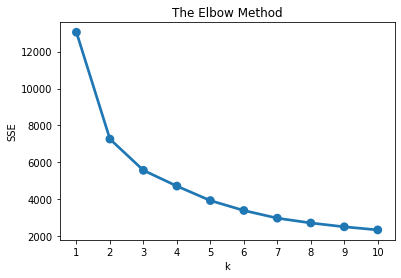

In [ ]:
from sklearn.cluster import KMeans
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [ ]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(customers_normalized)
model.labels_.shape

(4350,)

In [ ]:
customers["Cluster"] = model.labels_
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0        186.16     19.37        367.70  1644
1         42.78     67.47       1009.54  1924
2         18.07    309.77       7993.75   782

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


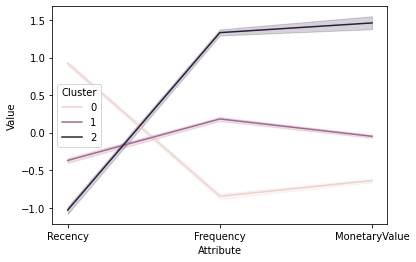

In [ ]:
# Create the dataframe
df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = model.labels_
# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()
# Visualize it
sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
list1 = ['Recency','Frequency','MonetaryValue']

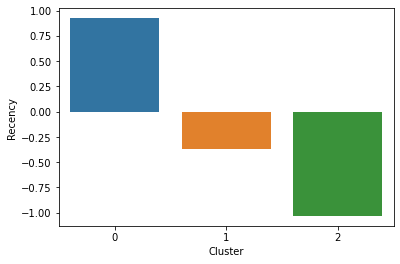

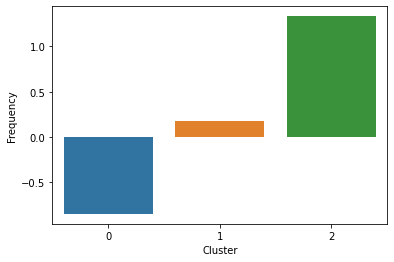

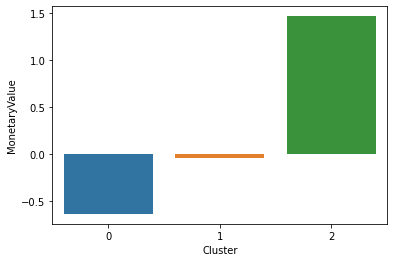

In [ ]:
avg_df = df_normalized.groupby(['Cluster'], as_index=False).mean()
for i in list1:
    sns.barplot(x='Cluster',y=str(i),data=avg_df)
    plt.show()